In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_squared_error
import random

# These paths can be updated to your appropriate filepath
test_a_pred = pickle.load(open('/content/drive/MyDrive/cde_uncert/test_a_preds.p', "rb"))
test_a = pickle.load(open('/content/drive/MyDrive/cde_uncert/test_a.p', "rb"))
test_y_pred = pickle.load(open('/content/drive/MyDrive/cde_uncert/test_y_preds.p', "rb"))
test_y = pickle.load(open('/content/drive/MyDrive/cde_uncert/test_y.p', "rb"))
active_y = pickle.load(open('/content/drive/MyDrive/cde_uncert/active.p', "rb"))

In [3]:
def compute_mse_loss_np(ground_truth_outputs, predictions, active_entries):
    mse_loss = np.mean((ground_truth_outputs - predictions)**(2) * active_entries)
    return mse_loss

In [4]:

percents = np.linspace(0.01, 0.99, 100)

# from torch to numpy
true = test_y.cpu().detach().numpy()
preds = test_y_pred[0].cpu().detach().numpy()
active = active_y.cpu().detach().numpy()

# compute ground truth errors
errors = np.abs(preds - true)

errors = np.sum(errors, axis=1)

uncert = np.argsort(errors)

amounts = percents * uncert.shape[0]

# compute the rmse
rmseval = compute_mse_loss_np(true[:,:], preds[:,:], active[:,:])

# get rmse for the oracle
rmse_oracle = []
rmse_oracle.append(rmseval)
for amount in amounts:
    excl = uncert[: -int(amount)]

    rmseval = compute_mse_loss_np(true[excl, :], preds[excl, :], active[excl, :])

    rmse_oracle.append(rmseval)


In [5]:
std_dev = np.std((test_y_pred[0].cpu().detach().numpy()),axis=1)

uncert = np.argsort(std_dev)

amounts = percents * uncert.shape[0]

# compute true value
val = compute_mse_loss_np(true[:, :], preds[:, :], active[:, :])

rmse_oracle_true = []

rmse_oracle_true.append(val)

excl_list=[]
for amount in amounts:
    excl = uncert[: -int(amount)]

    excl_list.append(excl)

    start = 0
    end = int(amount)

    rmseval = compute_mse_loss_np(true[excl, :], preds[excl, :], active[excl, :])

    rmse_oracle_true.append(rmseval)

In [6]:

std_dev =np.std((test_y_pred[0].cpu().detach().numpy()),axis=1)

uncert = np.argsort(std_dev)


val = compute_mse_loss_np(true[:, :], preds[:, :], active[:, :])

# get results for random
rmse_oracle_rand = []
rmse_oracle_rand.append(val)
population = range(0, uncert.shape[0])
for amount in amounts:
    excl = uncert[: -int(amount)]

    excl = random.sample(population, int(amount))

    start = 0
    end = int(amount)

    rmseval = compute_mse_loss_np(true[excl, :], preds[excl, :], active[excl, :])
    rmse_oracle_rand.append(rmseval)

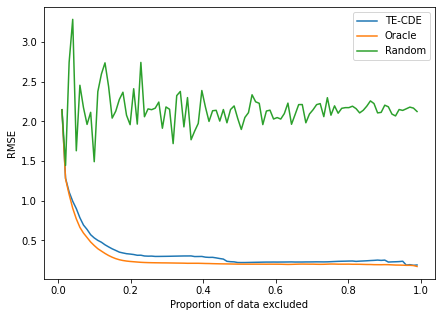

In [9]:
plt.figure(figsize=(7,5))

plt.plot(percents, np.sqrt(np.array(rmse_oracle_true[:-1])), label='TE-CDE')
plt.plot(percents, np.sqrt(np.array(rmse_oracle[:-1])), label='Oracle')
plt.plot(percents, np.sqrt(np.array(rmse_oracle_rand[:-1])), label='Random')
plt.ylabel('RMSE')
plt.xlabel('Proportion of data excluded')
plt.legend()

In [10]:
def compute_aoc_curve_and_value(rmses, rmse_oracle):
    """
    Computes AOC curve and the AUSE
    Args:
    rmses (list): rmses for a specific model
    rmse_oracle (list): rmse for the oracle
    Returns:
    aoc_list (list): sparsification curve
    auc (float): AUSE value
    """
    from sklearn.metrics import auc

    assert len(rmses) == len(rmse_oracle)

    aoc_list = np.array(rmses) - np.array(rmse_oracle)

    xx = np.linspace(0, 100, 100)
    yy = aoc_list

    return aoc_list, auc(xx, yy)

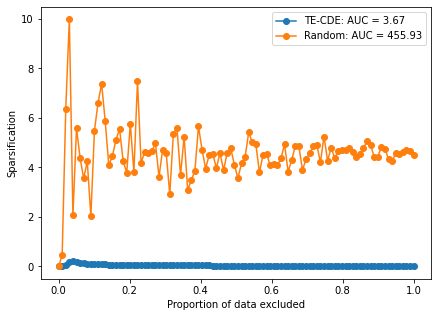

In [12]:
mean_uncert, auc_score = compute_aoc_curve_and_value(rmse_oracle_rand[:-1], rmse_oracle[:-1])
mean_uncert1, auc_score1 = compute_aoc_curve_and_value(rmse_oracle_true[:-1], rmse_oracle[:-1])

plt.figure(figsize=(7,5))
xx = np.linspace(0, 1, 10)

auc_label = f"AUC: {auc_score}"
plt.plot(np.linspace(0, 1, 100), mean_uncert1, marker="o", label=f'TE-CDE: AUC = {round(auc_score1,2)}')
plt.plot(np.linspace(0, 1, 100), mean_uncert, marker="o", label=f'Random: AUC = {round(auc_score,2)}')

plt.ylabel('Sparsification')
plt.xlabel('Proportion of data excluded')
plt.legend()